In [2]:
from platform import python_version

print(python_version())

3.9.7


# Цель
Выбрать один из трёх регионов для разработки нового нефтяного месторождения.

# Задачи
- посмотреть данные, при необходимости провести EDA
- построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль с наименьшим риском убытков
- определить скважины с самыми высокими оценками значений
- оценить риски
- решить в каком регионе добывать нефть

# Описание
Добывающей компании нужно решить, где бурить новую скважину.
Собраны характеристики пробы нефти для скважин: качество нефти и объём её запасов по трем регионам. Характеристики для каждой скважины в регионе уже известны.
Построена модель для предсказания объёма запасов в новых скважинах.
Выбраны скважины с самыми высокими оценками значений.
Определены регионы с максимальной суммарной прибылью отобранных скважин.
Построена модель для определения региона, где добыча принесёт наибольшую прибыль.
Проанализирована возможная прибыль и риски техникой Bootstrap.

In [3]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from numpy.random import RandomState 

# Секция 1 (EDA)
<font size="3">**1. Загрузка и подготовка данных.**</font>

In [4]:
# загрузка данных
# 3 файла - 3 месторождения

df_geo_0 = pd.read_csv('datasets/geo_data_0.csv')
df_geo_1 = pd.read_csv('datasets/geo_data_1.csv')
df_geo_2 = pd.read_csv('datasets/geo_data_2.csv')

In [5]:
# проверка, правильно ли произошло считывание данных

print(df_geo_0.head(),'\n')
print(df_geo_1.head(),'\n')
print(df_geo_2.head())

# id — номера идентификаторы скважин
# f0, f1, f2 — характеристики скважин (эти фичи без описания, но известно, что они )
# product — объем запасов нефти в скважине (в тыс. баррелей)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647 

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305 

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [6]:
print('Количество скважин:', len(df_geo_0['id']))

Количество скважин: 100000


**Итак..** Данные загружены корректно. <br>
В качестве скважин здесь принимаются непробуренные траектории скважин, поэтому их так много. Ни на одном месторождении не бывает такого количества пробуренных скважин.

In [7]:
# вывод общих характеристик: тип данных, кол-во уникальных значений

print(df_geo_0.info(),'\n')
print(df_geo_1.info(),'\n')
print(df_geo_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Colu

**Отметим:** NA-values нет, *id* строка (OK), другие фичи имеют тип float (OK)

In [8]:
# статистика:
print(df_geo_0.describe(),'\n')
print(df_geo_1.describe(),'\n')
print(df_geo_2.describe())

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%     

**Notice:**
1. фичи (f0,f1,f2) могут иметь отрицательные значения
2. средние значения (f0,f1) по разным месторождениям значительно отличаются f0:(0,5 -> 1,14 -> 0.002) и f1:(0.25 -> -4,79 -> -0,02)
3. Среди значений есть выбросы: $\mu + 3*\sigma $ (подробнее ниже) <br>
Наличие выбросов не означает, что необходимо фильтровать данные. По сути без дополнительной информации (что из себя представляют эти данные) не стоит очищать данные. <br>
Вариант 1 ("хороший"). Выбросами могут оказаться самые лучшие по показателям скважины. <br>
Вариант 2 ("плохой"). Выбросами могут оказаться скважины на границе месторождения, где более низкое качество сейсмических данных.

In [9]:
# ниже идет вывод параметров, по которым наблюдаются выбросы, это сделано для каждого месторождения
# в данном случае критерий mu+3*sigma

def print_outliers(df_column):
    three_sigma = df_column.mean() + 3 * df_column.std()
    maximum = df_column.max()
    if three_sigma >= maximum :
        print ('No outliers        for {:} mu+3*sigma: {:.2} great than {:.2}'.format(
                                                df_column.name, three_sigma, maximum))
    else:
        print ('There are outliers for {:} mu+3*sigma: {:.2} less than {:.2}'.format(
                                                df_column.name, three_sigma, maximum))

print('geo_0:')
print_outliers(df_geo_0.f0)
print_outliers(df_geo_0.f1)
print_outliers(df_geo_0.f2)
print()

print('geo_1:')
print_outliers(df_geo_1.f0)
print_outliers(df_geo_1.f1)
print_outliers(df_geo_1.f2)
print()

print('geo_2:')
print_outliers(df_geo_2.f0)
print_outliers(df_geo_2.f1)
print_outliers(df_geo_2.f2)

geo_0:
No outliers        for f0 mu+3*sigma: 3.1 great than 2.4
No outliers        for f1 mu+3*sigma: 1.8 great than 1.3
There are outliers for f2 mu+3*sigma: 1.2e+01 less than 1.6e+01

geo_1:
There are outliers for f0 mu+3*sigma: 2.8e+01 less than 2.9e+01
There are outliers for f1 mu+3*sigma: 1.1e+01 less than 1.9e+01
No outliers        for f2 mu+3*sigma: 7.6 great than 5.0

geo_2:
There are outliers for f0 mu+3*sigma: 5.2 less than 7.2
There are outliers for f1 mu+3*sigma: 5.2 less than 7.8
There are outliers for f2 mu+3*sigma: 1.3e+01 less than 1.7e+01


In [10]:
# проверка наличия дубликатов
print('There are {:} duplicates in df_geo_0'.format(df_geo_0.duplicated().sum()))
print('There are {:} duplicates in df_geo_1'.format(df_geo_1.duplicated().sum()))
print('There are {:} duplicates in df_geo_2'.format(df_geo_2.duplicated().sum()))

There are 0 duplicates in df_geo_0
There are 0 duplicates in df_geo_1
There are 0 duplicates in df_geo_2


**Итак...** Дубликатов нет, нет необходимости фильтровать данные.

In [11]:
# проверка данных на уникальность значений

def print_num_uniques(df_column):
    print('{:} unique values: {:}'.format(df_column.name, len(df_geo_0['f0'].unique())))

print('geo_0:')
print_num_uniques(df_geo_0['f0'])
print_num_uniques(df_geo_0['f1'])
print_num_uniques(df_geo_0['f2'])
print_num_uniques(df_geo_0['product'])
print()

print('geo_1:')
print_num_uniques(df_geo_1['f0'])
print_num_uniques(df_geo_1['f1'])
print_num_uniques(df_geo_1['f2'])
print_num_uniques(df_geo_1['product'])
print()

print('geo_2:')
print_num_uniques(df_geo_2['f0'])
print_num_uniques(df_geo_2['f1'])
print_num_uniques(df_geo_2['f2'])
print_num_uniques(df_geo_2['product'])
print()

geo_0:
f0 unique values: 100000
f1 unique values: 100000
f2 unique values: 100000
product unique values: 100000

geo_1:
f0 unique values: 100000
f1 unique values: 100000
f2 unique values: 100000
product unique values: 100000

geo_2:
f0 unique values: 100000
f1 unique values: 100000
f2 unique values: 100000
product unique values: 100000



**Итак...** Все значения уникальны

[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]
[[<AxesSubplot:title={'center':'f0'}> <AxesSubplot:title={'center':'f1'}>]
 [<AxesSubplot:title={'center':'f2'}>
  <AxesSubplot:title={'center':'product'}>]]


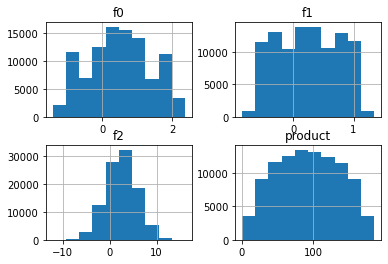

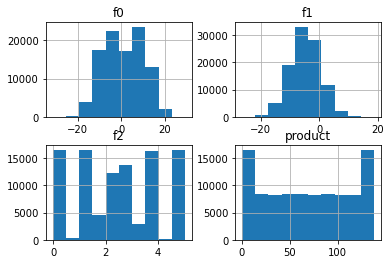

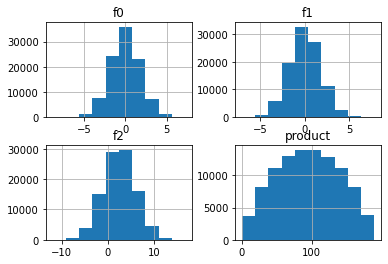

In [12]:
# вывод гистограмм (визуальное изучение данных)

print(df_geo_0.hist())
print(df_geo_1.hist())
print(df_geo_2.hist())

**Отметим:** все фичи и целевое значение df_geo_0 визуально имеют нормальное распределение

In [13]:
# проверка гипотезы (нормальное ли распределение)
# null hypothesis: фичи и целевая функция распределены нормально
# используется библиотека stats и функция normaltest (критерий Пирсона)
# выводится P-value

print('df_geo_0:')
for name_col in df_geo_0:
    if name_col != 'id':
        print('P-value of {:}: {:}'.format(name_col, st.normaltest(df_geo_0[name_col]).pvalue))

print('df_geo_1:')
for name_col in df_geo_1:
    if name_col != 'id':
        print('P-value of {:}: {:}'.format(name_col, st.normaltest(df_geo_1[name_col]).pvalue))
        
print('df_geo_2:')
for name_col in df_geo_2:
    if name_col != 'id':
        print('P-value of {:}: {:}'.format(name_col, st.normaltest(df_geo_2[name_col]).pvalue))

df_geo_0:
P-value of f0: 0.0
P-value of f1: 0.0
P-value of f2: 2.5829362598194747e-13
P-value of product: 0.0
df_geo_1:
P-value of f0: 0.0
P-value of f1: 0.03276406499792999
P-value of f2: 0.0
P-value of product: 0.0
df_geo_2:
P-value of f0: 0.5371167431415932
P-value of f1: 0.11763198211551353
P-value of f2: 2.873142751023688e-05
P-value of product: 0.0


**Отметим:** мы можем отвергнуть гипотезу если $P_{value} < \alpha$ <br>
Для $\alpha=0.05$ мы можем с уверенностью отвергнуть все кроме df_geo_2['f0'] и df_geo_2['f1'] <br>
Хотя казалось визуально, что данные распределены нормально, но это оказалось не так.

# Результат по Секции 1
<font size="2">
1. <b> Данные были загружены корректно </b>. Получили 3 таблицы. <br>
2. Нет NA-values и дубликатов. Все значения уникальны. <br>
3. Типы данных корректны по смыслу. <br>
4. <b> Exploratory Data Analysis(EDA) здесь не нужен </b>. Данные подготовлены достаточно, чтобы на их основе можно было построить модель. <br>
5. df_geo_2['f0'] и df_geo_2['f1'] по критерию Пирсона распределены нормально
    
    


# Секция 2
Необходиом обучить и протестировать модель для каждого региона:<br>
В данном случае для обучения будет использоваться только линейная модель

In [14]:
# вводится функция, чтобы не дублировать расчеты для каждого региона
# линейная модель позволяет за секунды проводить расчеты

def rmse_linear_model(df):
    features = df[['f0','f1','f2']] # we don't use id, as it doesn't influence on the target value
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(
                    features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print('RMSE: {:.2f}'.format(mean_squared_error(target_valid, predicted_valid)**0.5))
    return model.predict(features)

In [18]:
# вывод RMSE

print('Region 0:')
predicted_values = rmse_linear_model(df_geo_0)
df_geo_0['prod_predicted'] = predicted_values
print('Region 1:')
predicted_values = rmse_linear_model(df_geo_1)
df_geo_1['prod_predicted'] = predicted_values
print('Region 2:')
predicted_values = rmse_linear_model(df_geo_2)
df_geo_2['prod_predicted'] = predicted_values

Region 0:
RMSE: 37.58
Region 1:
RMSE: 0.89
Region 2:
RMSE: 40.03


In [16]:
# сравнение расчета и целевого параметра

def plot_predictions(x,y):
    plt.figure()
    plt.plot(x, y, '.')
    plt.plot([0, 200], [0, 200], linestyle='--')
    #plt.xlim(0,1)
    #plt.ylim(0,1)
    plt.ylabel("Product")
    plt.xlabel("Predited reserves")
    plt.title("Predicted vs True")
    plt.show()

Region 0:


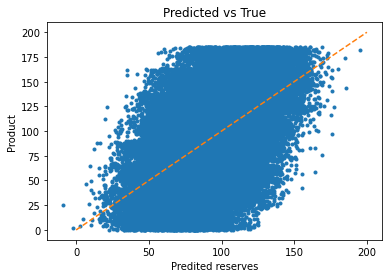

Region 1:


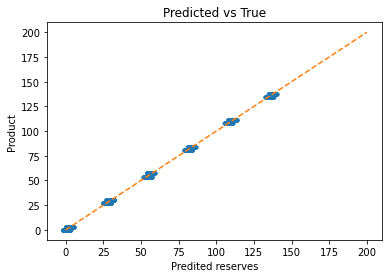

Region 2:


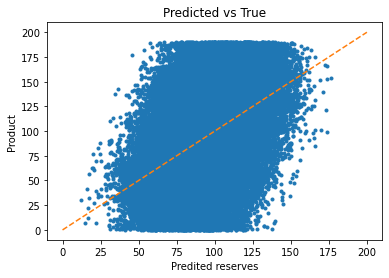

In [17]:
print('Region 0:')
plot_predictions(df_geo_0['prod_predicted'],df_geo_0['product'])
print('Region 1:')
plot_predictions(df_geo_1['prod_predicted'],df_geo_1['product'])
print('Region 2:')
plot_predictions(df_geo_2['prod_predicted'],df_geo_2['product'])

# Результаты по секции 2
<font size="2">
1. Была разработана линейная модель для расчета целевой функции (объема запасов нефти) <br>
2. На графике хорошо видно, качество модели и почему RMSE для регионов 0 и 2 значительно выше. В целом такой прогноз для регионов 0 и 2 с трудом можно назвать удовлетворительным. Разброс данных очень значительный. <br>
3. Довольно неплохой прогноз для Region 1 (RMSE is 0.89). Данные по всей видимости синтетические, так как "облака данных" лежат практически на прямой. <br>

# Секция 3
Расчет прибыли для каждого месторождения. <br>
Определение объема запасов достаточного для безубыточной разработки новой скважины. <br>
Сравнение полученного значения со средним объемом запасов в каждом регионе. <br>

In [19]:
# key values
num_wells_region = 500 # study of 500 points is carried
num_wells_best = 200   # pick the best 200 points for the profit calculation
budget = 1e8           # budget to drill best wells
price_barrel = 4.5     # price of 1 barrel
risk_bound = 0.025     # keep only the regions with the risk of losses lower than 2.5%

In [20]:
# calculate cost of 1 well based on total budget
cost_one_well = 1.0 * budget / num_wells_best

# calculate what volume of reserves we need to obtain based on the available budget
volume_reserves_zero_profit = 1.0 * budget / price_barrel
# print it
text = 'Total volume of reserves we should obtain in case of zero profit:'
print(' {:} {:.1} thousand of barrels'.format(text, volume_reserves_zero_profit / 1000))

# calculate what volume of reserves **by 1 well** we need to obtain
volume_reserves_one_well_zero_profit = 1.0 * budget / price_barrel / num_wells_best
# print it
text = 'The volume of reserves sufficient for developing a new well without losses:'
print(' {:} {:.2f} thousand of barrels'.format(text, volume_reserves_one_well_zero_profit / 1000))

 Total volume of reserves we should obtain in case of zero profit: 2e+04 thousand of barrels
 The volume of reserves sufficient for developing a new well without losses: 111.11 thousand of barrels


**Отметим**
Средний объем прогнозируемых запасов по регионам: Region 0: 92.59; Region 1: 68.73; Region 2: 94.97;  <br>
Объем запасов достаточный для разработки скважины без потерь: 111.11
Таким образом наша экономика (когда мы рассчитываем средний объем для всех скважин отрицательная (невыгодная).
Тем не менее станет лучше, если будут выбраны наилучшие скважины, особенно, если модель позволяет делать качественный прогноз.

# Результат секции 3
<font size="2">
1. Теперь мы готовы оценить прибыль для каждого региона. <br>
2. В нашем бюджете предусмотрено бурение 200 нефтяных скважин. Безубыточный объем запасов в одной скважине составляет 111,11 тыс. баррелей. По нашей модели каждая скважина в Районе 0 в среднем может дать нам 92,59 тыс баррелей (меньше). Однако среднее значение не дает нам информации об отклонениях от него. Если у нас есть очень хорошая модель и если стандартное отклонение высокое, мы получим хороший экономический результат на следующем шаге. <br>
3. Можно предположить, что регион 1 имеет хорошие шансы стать лучшим регионом. Ниже проводится проверка этого предположения.

# Секция 4
Функция для расчета прибыли от набора выбранных нефтяных скважин и прогнозных значений.
Рекомендации района разработки нефтяных скважин.
Расчет прибыли по полученному объему запасов.

In [22]:
# define funtion to calculate profit of the wells
def calculate_profit(model_volume, real_volume, num):
    index_best_well = model_volume.sort_values(ascending=False)[:num].index # find index of the best wells
    real_volume = real_volume[index_best_well] # find real volume of reserves in the best wells
    total_volume = real_volume.sum() # return total volume of reserves in the best wells
    return total_volume * price_barrel * 1e3 - budget # return profit (revenue minus budget)

In [19]:
sample = df_geo_0.sample(num_wells_region, random_state=12345)
print('Region0 profit: {:.2f}'.format(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best)))
sample = df_geo_1.sample(num_wells_region, random_state=12345)
print('Region1 profit: {:.2f}'.format(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best)))
sample = df_geo_2.sample(num_wells_region, random_state=12345)
print('Region2 profit: {:.2f}'.format(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best)))

Region0 profit: 1967713.97
Region1 profit: 3121725.38
Region2 profit: -173046.57


**Отметим** <br>
! Эти расчеты выполнены для рандомных выборок !
1. Нельзя выбрать наилучший регион, основываясь только на этих данных, потому что выбор скважин производился случайным образом.
Можно предворительно предположить, что наилуший регион Region 1.
2. Доход по Region1 (103.1 mln USD) > бюджет (100.0 mln USD). Это хороший знак, значит можно сделать проект экономически целесообразным.

# Результат по секции 4
<font size="2">
1. Функция для расчета прибыли написана. <br>
2. Region1 имеет положительный баланс доходы/затраты, разница +3 mln USD

# Секция 5
Расчет рисков и прибыли по каждому региону <br>
Оценка рисков

In [26]:
# save profits during bootstrapping
state = RandomState(12345)

profit_region_0 = []
profit_region_1 = []
profit_region_2 = []

for k in range(1000):
    sample = df_geo_0.sample(num_wells_region, replace=True, random_state=state)
    profit_region_0.append(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best))
    
    sample = df_geo_1.sample(num_wells_region, random_state=state)
    profit_region_1.append(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best))
    
    sample = df_geo_2.sample(num_wells_region, random_state=state)
    profit_region_2.append(calculate_profit(sample['prod_predicted'], sample['product'], num_wells_best))



In [27]:
# find average profit
average_profit_region_0 = pd.Series(profit_region_0).mean()
average_profit_region_1 = pd.Series(profit_region_1).mean()
average_profit_region_2 = pd.Series(profit_region_2).mean()
print('Average profit Region 0:', average_profit_region_0 / 1000000, 'mln USD')
print('Average profit Region 1:', average_profit_region_1 / 1000000, 'mln USD')
print('Average profit Region 2:', average_profit_region_2 / 1000000, 'mln USD')

Average profit Region 0: 4.7925069866251775 mln USD
Average profit Region 1: 4.553627114171752 mln USD
Average profit Region 2: 3.591671708230166 mln USD


**Итак:** По каждому региону средний профит положительный. Наименьший для региона Region 2  +3.6 mln USD, наибольший для региона Region 0 + 4.8 mln USD.

In [28]:
# 95% confidence interval using the Student distribution
confidence_interval = st.t.interval(0.95, len(profit_region_0)-1, 
                                    loc=pd.Series(profit_region_0).mean(),
                                    scale=pd.Series(profit_region_0).sem()) 

print("Region 0 confidence interval 95%:", confidence_interval)

# 95% confidence interval using the Student distribution
confidence_interval = st.t.interval(0.95, len(profit_region_1)-1, 
                                    loc=pd.Series(profit_region_1).mean(),
                                    scale=pd.Series(profit_region_1).sem()) 

print("Region 1 confidence interval 95%:", confidence_interval)

# 95% confidence interval using the Student distribution
confidence_interval = st.t.interval(0.95, len(profit_region_2)-1, 
                                    loc=pd.Series(profit_region_2).mean(),
                                    scale=pd.Series(profit_region_2).sem()) 

print("Region 2 confidence interval 95%:", confidence_interval)

Region 0 confidence interval 95%: (4620789.20141389, 4964224.771836465)
Region 1 confidence interval 95%: (4426591.372906484, 4680662.85543702)
Region 2 confidence interval 95%: (3426040.109735584, 3757303.3067247476)


**Отметим:** Наблюдается положительный баланс в 95% доверительном интервале

<AxesSubplot:>

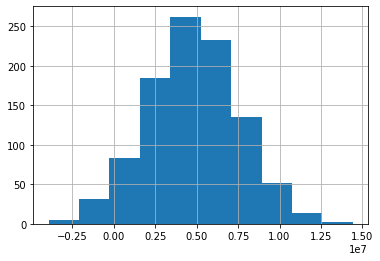

In [29]:
pd.Series(profit_region_0).hist()

In [30]:
# risk of looses determined by the negative profit
print('Region 0 risk of looses: {:}%'.format(st.percentileofscore(pd.Series(profit_region_0), 0)))
print('Region 1 risk of looses: {:}%'.format(st.percentileofscore(pd.Series(profit_region_1), 0)))
print('Region 2 risk of looses: {:}%'.format(st.percentileofscore(pd.Series(profit_region_2), 0)))

Region 0 risk of looses: 4.8%
Region 1 risk of looses: 1.4%
Region 2 risk of looses: 8.8%


# Результат Секции 5

1. Наилучший регион - это Region 1. Здесь наименьшие риски для достижения положительного баланса экономики (всего 1.4%), более того, здесь высокие значения профита в диапазоне (4426591.372906486, 4680662.855437022) USD в доверительном интервале 95% <br>
</div>
2. Другие регионы уступают (Region 1: 4.8%, Region 2: 8.8%). <br>
Region 0 confidence interval 95%: (4620789.201413887, 4964224.7718364615) <br>
Region 2 confidence interval 95%: (3426040.1097355834, 3757303.306724747)

# Вывод

Наилучшее решение - это разработка региона **Region 1** <br>
Здесь наименьший шанс для того, чтобы экономика перестала быть выгодной меньше 1.5% <br>
При этом эттот регион потенциально может дать самую высокую прибыль. <br>
Для этого региона была разработана хорошая линейная модель RMSE составляет 0,89. <br>
Анализируя более тщательно каждую скважину, можно будет еще улучшить эти показатели.
